Importing necessary libraries

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

Checking whether GPU is present and using it (T4 GPU).

In [ ]:
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
class Net(nn.Module):
  def __init__(self, in_features, out_features):
    super().__init__()


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import os
import shutil
import random
from pathlib import Path
from PIL import Image
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn, optim
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Paths to the dataset
dataset_path = '/content/drive/MyDrive/dataset'
ai_images_path = os.path.join(dataset_path, 'ai_images')
real_images_path = os.path.join(dataset_path, 'real_images')

# Commenting out the function to verify and clean images
# def verify_images(path):
#     for img_file in Path(path).rglob('*.*'):
#         try:
#             img = Image.open(img_file)
#             img.verify()  # Verify if the file is a valid image
#         except (IOError, SyntaxError) as e:
#             print(f'Removing invalid image: {img_file}')
#             os.remove(img_file)

# Verify and clean images
# verify_images(ai_images_path)
# verify_images(real_images_path)

# Function to check if the directories exist
def check_dirs_exist(base_dir, categories):
    train_dir = os.path.join(base_dir, 'train')
    test_dir = os.path.join(base_dir, 'test')
    for category in categories:
        if not os.path.exists(os.path.join(train_dir, category)) or not os.path.exists(os.path.join(test_dir, category)):
            return False
    return True

# Create directories for train and test sets if they do not exist
def create_split_dirs(base_dir, categories):
    train_dir = os.path.join(base_dir, 'train')
    test_dir = os.path.join(base_dir, 'test')
    for category in categories:
        os.makedirs(os.path.join(train_dir, category), exist_ok=True)
        os.makedirs(os.path.join(test_dir, category), exist_ok=True)
    return train_dir, test_dir

# Split data into training and testing sets
def split_data(source_dir, train_ratio=0.8):
    files = [f for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f))]
    random.shuffle(files)
    train_size = int(len(files) * train_ratio)
    train_files = files[:train_size]
    test_files = files[train_size:]

    return train_files, test_files

# Move files to train and test directories
def move_files(files, source_dir, dest_dir, category):
    for file in files:
        shutil.copy(os.path.join(source_dir, file), os.path.join(dest_dir, category, file))

# Perform data splitting and organizing if train and test directories do not exist
categories = ['ai_images', 'real_images']
if not check_dirs_exist(dataset_path, categories):
    print("Creating train and test directories and splitting data...")
    train_dir, test_dir = create_split_dirs(dataset_path, categories)

    for category in categories:
        source_dir = os.path.join(dataset_path, category)
        train_files, test_files = split_data(source_dir)
        move_files(train_files, source_dir, train_dir, category)
        move_files(test_files, source_dir, test_dir, category)
else:
    print("Train and test directories already exist. Skipping data splitting...")

# Data normalization and augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.RandomAffine(0, translate=(0.1, 0.1)),
        transforms.RandomGrayscale(p=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create PyTorch datasets and dataloaders
image_datasets = {x: datasets.ImageFolder(os.path.join(dataset_path, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4)
               for x in ['train', 'test']}

# Get dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

# Get class names
class_names = image_datasets['train'].classes

print(f"Classes: {class_names}")
print(f"Dataset sizes: {dataset_sizes}")
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(8 * 16 * 16, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

# Calculate the number of parameters to ensure they are within 10,000
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Initialize the model
num_classes = len(class_names)  # Number of classes in the dataset
model = SimpleCNN(num_classes=num_classes)
num_params = count_parameters(model)
print(f"Number of parameters in the model: {num_params}")

# Ensure the number of parameters is within 10,000
assert num_params <= 10000, "The model has more than 10,000 parameters!"

# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training the model
num_epochs = 25

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    for phase in ['train', 'test']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        if phase == 'train':
            scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

print('Training complete')

# Save the trained model
torch.save(model.state_dict(), 'cnn_model.pth')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train and test directories already exist. Skipping data splitting...
Classes: ['ai_images', 'real_images']
Dataset sizes: {'train': 623, 'test': 156}
Number of parameters in the model: 4322
Epoch 1/25
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.5160 Acc: 0.8154
test Loss: 0.4500 Acc: 0.8462
Epoch 2/25
----------
train Loss: 0.4388 Acc: 0.8475
test Loss: 0.5003 Acc: 0.8333
Epoch 3/25
----------
train Loss: 0.4505 Acc: 0.8427
test Loss: 0.4488 Acc: 0.8462
Epoch 4/25
----------
train Loss: 0.4168 Acc: 0.8475
test Loss: 0.4839 Acc: 0.8141
Epoch 5/25
----------
train Loss: 0.4157 Acc: 0.8443
test Loss: 0.4575 Acc: 0.8205
Epoch 6/25
----------
train Loss: 0.3861 Acc: 0.8523
test Loss: 0.4144 Acc: 0.8462
Epoch 7/25
----------
train Loss: 0.3870 Acc: 0.8459
test Loss: 0.4629 Acc: 0.8269
Epoch 8/25
----------
train Loss: 0.3942 Acc: 0.8427
test Loss: 0.4417 Acc: 0.8526
Epoch 9/25
----------
train Loss: 0.3951 Acc: 0.8411
test Loss: 0.4486 Acc: 0.8462
Epoch 10/25
----------
train Loss: 0.3814 Acc: 0.8379
test Loss: 0.4396 Acc: 0.8333
Epoch 11/25
----------
train Loss: 0.3939 Acc: 0.8475
test Loss: 0.4490 Acc: 0.8333
Epoch 12/25
----------
train Loss: 0.3895 Acc: 0.8427
test Loss: 0.4514 Acc: 0.8333
Epoch 13/25
----------


In [2]:
import os
import torch
from torch import nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Define the transformations for inference
data_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load class names (adjust according to your dataset)
class_names = ['ai_images', 'real_images']

# Load the pre-trained model
model = SimpleCNN(num_classes=len(class_names))  # Ensure to instantiate the same model structure
model.load_state_dict(torch.load('cnn_model.pth', map_location=torch.device('cpu')))
model.eval()  # Set the model to evaluation mode

# Function to predict and display an image
def predict_image(model, image_path, class_names):
    image = Image.open(image_path)
    image = data_transforms(image).unsqueeze(0)  # Add batch dimension
    outputs = model(image)
    _, preds = torch.max(outputs, 1)

    plt.imshow(image.squeeze().permute(1, 2, 0))  # Display the image
    plt.title(f'Predicted: {class_names[preds[0]]}')
    plt.axis('off')
    plt.show()

# Example usage: Predict on new images
new_images = [
    '/path/to/your/new_image1.jpg',
    '/path/to/your/new_image2.jpg'
]

for image_path in new_images:
    predict_image(model, image_path, class_names)


Epoch 1/10
----------
train Loss: 1.9375 Acc: 0.7929
test Loss: 0.4880 Acc: 0.8462
Epoch 2/10
----------
train Loss: 0.4563 Acc: 0.8363
test Loss: 0.4557 Acc: 0.8462
Epoch 3/10
----------
train Loss: 0.4410 Acc: 0.8459
test Loss: 0.4513 Acc: 0.8462
Epoch 4/10
----------
train Loss: 0.4268 Acc: 0.8459
test Loss: 0.4264 Acc: 0.8462
Epoch 5/10
----------
train Loss: 0.4284 Acc: 0.8459
test Loss: 0.4578 Acc: 0.8462
Epoch 6/10
----------
train Loss: 0.4267 Acc: 0.8459
test Loss: 0.3631 Acc: 0.8462
Epoch 7/10
----------
train Loss: 0.4029 Acc: 0.8459
test Loss: 0.3941 Acc: 0.8462
Epoch 8/10
----------
train Loss: 0.3920 Acc: 0.8459
test Loss: 0.3911 Acc: 0.8462
Epoch 9/10
----------
train Loss: 0.4080 Acc: 0.8459
test Loss: 0.3757 Acc: 0.8462
Epoch 10/10
----------
train Loss: 0.4386 Acc: 0.8459
test Loss: 0.4029 Acc: 0.8462
Training complete


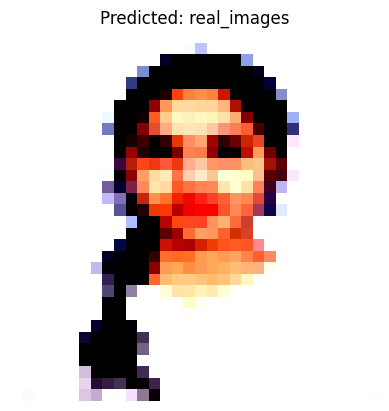

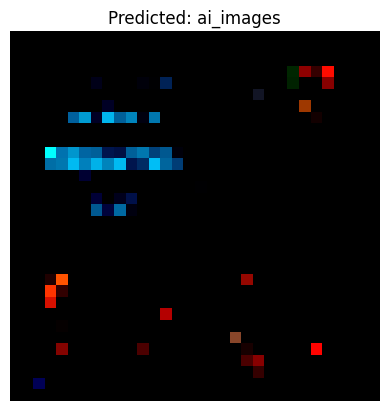

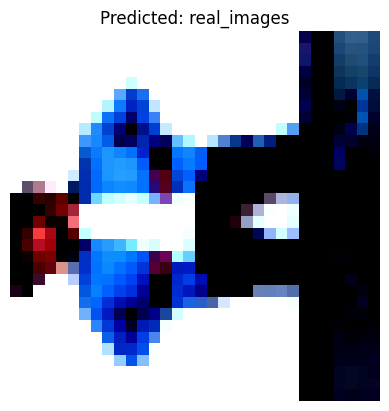

In [14]:
import os
import torch
from torch import nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Define the transformations for inference
data_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load class names (adjust according to your dataset)
class_names = ['ai_images', 'real_images']

# Load the pre-trained model
model = SimpleCNN(num_classes=len(class_names))  # Ensure to instantiate the same model structure
model.load_state_dict(torch.load('/content/cnn_model.pth', map_location=torch.device('cpu')))
model.eval()  # Set the model to evaluation mode

# Function to predict and display an image
def predict_image(model, image_path, class_names):
    image = Image.open(image_path)
    image = data_transforms(image).unsqueeze(0)  # Add batch dimension
    outputs = model(image)
    _, preds = torch.max(outputs, 1)

    plt.imshow(image.squeeze().permute(1, 2, 0))  # Display the image
    plt.title(f'Predicted: {class_names[preds[0]]}')
    plt.axis('off')
    plt.show()

# Example usage: Predict on new images
new_images = [
    '/content/Passport.jpg',
    '/content/midjourney_269.jpg',
    '/content/20230115_141423.jpg'
    # '/path/to/your/new_image2.jpg'
]

for image_path in new_images:
    predict_image(model, image_path, class_names)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Define the CNN architecture
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 32 * 32, 512)  # Assuming input images are 128x128
        self.fc2 = nn.Linear(512, 2)  # Binary classification (AI-generated vs real)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define the data transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load the dataset
train_dataset = ImageFolder(root='path/to/train_data', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialize the model, loss function, and optimizer
model = CustomCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(10):  # Number of epochs
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

print('Finished Training')
